<a href="https://colab.research.google.com/github/priyanshgoantiya/streamlit-web-app-on-indian-startup-funding/blob/master/IPL_Win_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
# ! pip install pickle

In [81]:
# !pip install --upgrade scikit-learn

In [82]:
# ! pip install scikit-learn

In [83]:
import sklearn
sklearn.__version__

'1.6.1'

In [84]:
# !pip install --upgrade streamlit

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
pd.set_option('display.max_columns',None)
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split

In [2]:
deliveries=pd.read_csv('/content/deliveries.csv')
matches=pd.read_csv('/content/matches.csv')

In [3]:
deliveries.shape

(260920, 17)

In [4]:
matches.shape

(1095, 20)

In [5]:
deliveries.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batter', 'bowler', 'non_striker', 'batsman_runs', 'extra_runs',
       'total_runs', 'extras_type', 'is_wicket', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')

In [6]:
deliveries.groupby(['match_id','inning'])['total_runs'].sum().reset_index()

,match_id,inning,total_runs
0,335982,1,222
1,335982,2,82
2,335983,1,240
3,335983,2,207
4,335984,1,129
...,...,...,...
2212,1426310,2,174
2213,1426311,1,175
2214,1426311,2,139
2215,1426312,1,113


In [7]:
total_run_df=deliveries[deliveries['inning']==1].groupby(['match_id','inning'])['total_runs'].sum().apply(lambda x:x+1).reset_index()
total_run_df.head()

,match_id,inning,total_runs
0,335982,1,223
1,335983,1,241
2,335984,1,130
3,335985,1,166
4,335986,1,111


In [8]:
match_df=pd.merge(matches,total_run_df[['match_id','total_runs']],left_on='id',right_on='match_id')

In [9]:
match_df.head()

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,match_id,total_runs
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,335982,223
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri,335983,241
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar,335984,130
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper,335985,166
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan,335986,111


In [10]:
match_df['team1'].unique()

array(['Royal Challengers Bangalore', 'Kings XI Punjab',
       'Delhi Daredevils', 'Mumbai Indians', 'Kolkata Knight Riders',
       'Rajasthan Royals', 'Deccan Chargers', 'Chennai Super Kings',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Gujarat Lions', 'Rising Pune Supergiants',
       'Rising Pune Supergiant', 'Delhi Capitals', 'Punjab Kings',
       'Lucknow Super Giants', 'Gujarat Titans',
       'Royal Challengers Bengaluru'], dtype=object)

In [11]:
match_df.loc[match_df['team1']=='Delhi Daredevils','team1']='Delhi Capitals'
match_df.loc[match_df['team2']=='Delhi Daredevils','team2']='Delhi Capitals'

match_df.loc[match_df['team1']=='Deccan Chargers','team1']='Sunrisers Hyderabad'
match_df.loc[match_df['team2']=='Deccan Chargers','team2']='Sunrisers Hyderabad'

In [12]:
match_df.loc[match_df['team1']=='Rising Pune Supergiants','team1']='Rising Pune Supergiant'
match_df.loc[match_df['team2']=='Rising Pune Supergiants','team2']='Rising Pune Supergiant'

In [13]:
match_df.loc[match_df['team1']=='Royal Challengers Bengaluru','team1']='Royal Challengers Bangalore'

In [14]:
match_df.loc[match_df['team2']=='Royal Challengers Bengaluru','team2']='Royal Challengers Bangalore'

In [15]:
match_df[match_df['team2']=='Royal Challengers Bengaluru']

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,match_id,total_runs


In [16]:
match_df.loc[match_df['team1']=='Kings XI Punjab','team1']='Punjab Kings'
match_df.loc[match_df['team2']=='Kings XI Punjab','team2']='Punjab Kings'

In [17]:
teams=['Royal Challengers Bangalore', 'Punjab Kings', 'Delhi Capitals',
       'Mumbai Indians', 'Sunrisers Hyderabad', 'Rajasthan Royals',
       'Chennai Super Kings', 'Kolkata Knight Riders']

In [18]:
match_df=match_df[match_df['team1'].isin(teams)]
match_df=match_df[match_df['team2'].isin(teams)]

In [19]:
match_df['team1'].unique()

array(['Royal Challengers Bangalore', 'Punjab Kings', 'Delhi Capitals',
       'Mumbai Indians', 'Kolkata Knight Riders', 'Rajasthan Royals',
       'Sunrisers Hyderabad', 'Chennai Super Kings'], dtype=object)

In [20]:
match_df.shape

(896, 22)

In [21]:
match_df[match_df['method']=='D/L'].style.background_gradient(cmap='plasma')

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,match_id,total_runs
38,336022,2007/08,Delhi,2008-05-17,League,DPMD Jayawardene,Feroz Shah Kotla,Delhi Capitals,Punjab Kings,Delhi Daredevils,bat,Kings XI Punjab,runs,6.000000,89.000000,8.000000,N,D/L,AV Jayaprakash,RE Koertzen,336022,119
41,336025,2007/08,Kolkata,2008-05-18,League,M Ntini,Eden Gardens,Kolkata Knight Riders,Chennai Super Kings,Kolkata Knight Riders,bat,Chennai Super Kings,runs,3.000000,53.000000,8.000000,N,D/L,Asad Rauf,K Hariharan,336025,150
60,392183,2009,Cape Town,2009-04-19,League,DL Vettori,Newlands,Delhi Capitals,Punjab Kings,Delhi Daredevils,field,Delhi Daredevils,wickets,10.000000,54.000000,6.000000,N,D/L,MR Benson,SD Ranade,392183,105
63,392186,2009,Durban,2009-04-21,League,CH Gayle,Kingsmead,Punjab Kings,Kolkata Knight Riders,Kolkata Knight Riders,field,Kolkata Knight Riders,runs,11.000000,69.000000,9.200000,N,D/L,DJ Harper,SD Ranade,392186,159
89,392214,2009,Centurion,2009-05-07,League,ML Hayden,SuperSport Park,Chennai Super Kings,Punjab Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,12.000000,187.000000,18.000000,N,D/L,DJ Harper,TH Wijewardene,392214,186
221,501245,2011,Kolkata,2011-05-07,League,Iqbal Abdulla,Eden Gardens,Kolkata Knight Riders,Chennai Super Kings,Chennai Super Kings,bat,Kolkata Knight Riders,runs,10.000000,52.000000,10.000000,N,D/L,Asad Rauf,PR Reiffel,501245,115
231,501255,2011,Bangalore,2011-05-14,League,CH Gayle,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Royal Challengers Bangalore,wickets,4.000000,102.000000,13.000000,N,D/L,RE Koertzen,RB Tiffin,501255,90
429,733993,2014,Delhi,2014-05-10,League,DW Steyn,Feroz Shah Kotla,Delhi Capitals,Sunrisers Hyderabad,Sunrisers Hyderabad,field,Sunrisers Hyderabad,wickets,8.000000,43.000000,5.000000,N,D/L,RM Deshpande,BNJ Oxenford,733993,144
476,829743,2015,Visakhapatnam,2015-04-22,League,DA Warner,Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium,Sunrisers Hyderabad,Kolkata Knight Riders,Kolkata Knight Riders,field,Sunrisers Hyderabad,runs,16.000000,118.000000,12.000000,N,D/L,RK Illingworth,VA Kulkarni,829743,177
508,829807,2015,Hyderabad,2015-05-15,League,V Kohli,"Rajiv Gandhi International Stadium, Uppal",Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,bat,Royal Challengers Bangalore,wickets,6.000000,81.000000,6.000000,N,D/L,AK Chaudhary,HDPK Dharmasena,829807,136


In [22]:
match_df['method'].unique()

array([nan, 'D/L'], dtype=object)

In [23]:
match_df['method'].fillna(0,inplace=True)

<ipython-input-23-74f0b79661a9>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  match_df['method'].fillna(0,inplace=True)


In [24]:
match_df=match_df[match_df['method']==0]

In [25]:
match_df=match_df[['match_id','city','winner','total_runs']]
match_df.head()

,match_id,city,winner,total_runs
0,335982,Bangalore,Kolkata Knight Riders,223
1,335983,Chandigarh,Chennai Super Kings,241
2,335984,Delhi,Delhi Daredevils,130
3,335985,Mumbai,Royal Challengers Bangalore,166
4,335986,Kolkata,Kolkata Knight Riders,111


In [26]:
delivery_df=pd.merge(match_df,deliveries,on='match_id')
delivery_df.head()

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs_y,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,Bangalore,Kolkata Knight Riders,223,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,Bangalore,Kolkata Knight Riders,223,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,Bangalore,Kolkata Knight Riders,223,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,Bangalore,Kolkata Knight Riders,223,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,Bangalore,Kolkata Knight Riders,223,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN


In [27]:
delivery_df=delivery_df[delivery_df['inning']==2]
delivery_df

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs_y,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
124,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN
125,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,NaN,NaN,NaN
126,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN
127,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN
128,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210963,1426312,Chennai,Kolkata Knight Riders,114,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,AK Markram,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN
210964,1426312,Chennai,Kolkata Knight Riders,114,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,AK Markram,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
210965,1426312,Chennai,Kolkata Knight Riders,114,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,Shahbaz Ahmed,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
210966,1426312,Chennai,Kolkata Knight Riders,114,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,Shahbaz Ahmed,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN


In [28]:
# '''So by observation we can observe that in the matchdf we had taken
# firstinnings total runs,right and in the second case,that is in the
# delivery dataframe we considered second inning runs,as our main aim
# is to find the probability of either teams to win or loose,we need
# current runs and runrate,so for current runs,we can apply groupby
# on matchid and take the cummulative sum wrt total_runs_y,now,basically
# totalruns was present in matchdf as well as deliveries_df,but as we merged
# both the dataframes,it resulted in total_runs_x,and total_runs_y,
# so total_runs_x is the first innings runs and total_runs_y are the second
# innings runs,ball by ball,by applying cummulative sum,this becomes
# current score


# total_runs_y gives the run scored after each ball,so in the second innings,
# we want to get the total second innings runs,so we will groupby match id
# and will apply the cummulative sum'''

delivery_df['Current_score']=delivery_df.groupby('match_id')['total_runs_y'].cumsum()

In [29]:
delivery_df['runs_left']=delivery_df['total_runs_x']-delivery_df['Current_score']
delivery_df.head()

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs_y,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,Current_score,runs_left
124,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,1,222
125,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,NaN,NaN,NaN,2,221
126,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN,2,221
127,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN,3,220
128,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,4,219


In [30]:
delivery_df['over'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [31]:
# Map the over column from 0-19 to 1-20
delivery_df['over'] = delivery_df['over'] + 1

In [32]:
delivery_df['remaining_balls'] = 126- (delivery_df['over'] * 6+delivery_df['ball'])

In [33]:
delivery_df.head(10)

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs_y,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,Current_score,runs_left,remaining_balls
124,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,1,222,119
125,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,NaN,NaN,NaN,2,221,118
126,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN,2,221,117
127,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN,3,220,116
128,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,4,219,115
129,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,6,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN,4,219,114
130,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,7,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN,4,219,113
131,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,2,1,R Dravid,I Sharma,W Jaffer,0,0,0,NaN,1,R Dravid,bowled,NaN,4,219,113
132,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,2,2,V Kohli,I Sharma,W Jaffer,0,0,0,NaN,0,NaN,NaN,NaN,4,219,112
133,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,2,3,V Kohli,I Sharma,W Jaffer,0,4,4,legbyes,0,NaN,NaN,NaN,8,215,111


In [34]:
delivery_df['player_dismissed'].fillna(0,inplace=True)

<ipython-input-34-5e4739b97d22>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  delivery_df['player_dismissed'].fillna(0,inplace=True)


In [35]:
delivery_df['player_dismissed']=delivery_df['player_dismissed'].apply(lambda x:x if x==0 else 1)

In [36]:
delivery_df['player_dismissed']=delivery_df['player_dismissed'].astype(int)

In [37]:
delivery_df['player_dismissed'].unique()

array([0, 1])

In [38]:
wickets=delivery_df.groupby('match_id')['player_dismissed'].cumsum().values

In [39]:
delivery_df['wickets']=10-wickets

In [40]:
((delivery_df['Current_score']*6)/(120-delivery_df['remaining_balls']))

,0
124,6.000000
125,6.000000
126,4.000000
127,4.500000
128,4.800000
...,...
210963,11.186441
210964,11.100000
210965,11.016393
210966,10.935484


In [41]:
delivery_df['Current_run_rate']=((delivery_df['Current_score']*6)/(120-delivery_df['remaining_balls']))

In [42]:
((delivery_df['runs_left']*6)/(delivery_df['remaining_balls']))

,0
124,11.193277
125,11.237288
126,11.333333
127,11.379310
128,11.426087
...,...
210963,0.393443
210964,0.300000
210965,0.203390
210966,0.103448


In [43]:
delivery_df['required_run_rate']=((delivery_df['Current_score']*6)/(delivery_df['remaining_balls']))

In [44]:
def result(row):
  return 1 if row['batting_team']==row['winner'] else 0

In [45]:
delivery_df['result']=delivery_df.apply(result,axis=1)
delivery_df.head()

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs_y,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,Current_score,runs_left,remaining_balls,wickets,Current_run_rate,required_run_rate,result
124,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,0,NaN,NaN,1,222,119,10,6.0,0.050420,0
125,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,0,NaN,NaN,2,221,118,10,6.0,0.101695,0
126,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,0,NaN,NaN,2,221,117,10,4.0,0.102564,0
127,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,0,NaN,NaN,3,220,116,10,4.5,0.155172,0
128,335982,Bangalore,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,0,NaN,NaN,4,219,115,10,4.8,0.208696,0


<ipython-input-46-93abf76fd9e1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='result', data=delivery_df,palette='magma')


<Axes: xlabel='result', ylabel='count'>

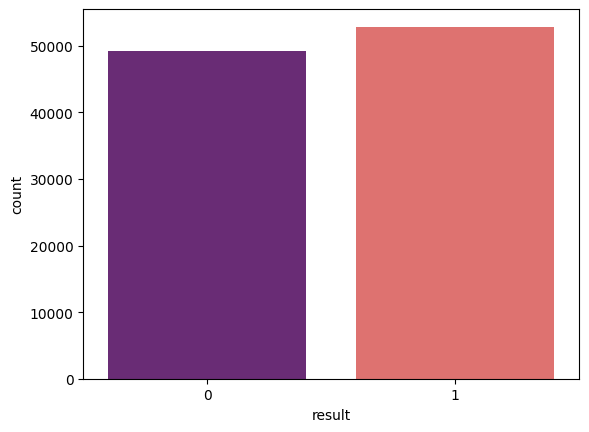

In [46]:

# Correct usage of sns.countplot with the 'x' parameter
sns.countplot(x='result', data=delivery_df,palette='magma')

In [47]:
temp_df=delivery_df['result'].value_counts().reset_index()

In [48]:
import plotly.express as px
px.bar(temp_df,x='result',y='count')

In [49]:
delivery_df.columns

Index(['match_id', 'city', 'winner', 'total_runs_x', 'inning', 'batting_team',
       'bowling_team', 'over', 'ball', 'batter', 'bowler', 'non_striker',
       'batsman_runs', 'extra_runs', 'total_runs_y', 'extras_type',
       'is_wicket', 'player_dismissed', 'dismissal_kind', 'fielder',
       'Current_score', 'runs_left', 'remaining_balls', 'wickets',
       'Current_run_rate', 'required_run_rate', 'result'],
      dtype='object')

In [50]:
final_df=delivery_df[['batting_team','bowling_team','city','runs_left',
                        'remaining_balls','wickets','total_runs_x','Current_run_rate',
                        'required_run_rate','result']]

In [51]:
final_df.shape

(102034, 10)

In [52]:
final_df.isna().sum()

,0
batting_team,0
bowling_team,0
city,6012
runs_left,0
remaining_balls,0
wickets,0
total_runs_x,0
Current_run_rate,0
required_run_rate,0
result,0


In [53]:
final_df=final_df.dropna(subset='city')

In [54]:
final_df=final_df[final_df['remaining_balls']!=0]

In [55]:
final_df.head()

,batting_team,bowling_team,city,runs_left,remaining_balls,wickets,total_runs_x,Current_run_rate,required_run_rate,result
124,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,222,119,10,223,6.0,0.050420,0
125,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,221,118,10,223,6.0,0.101695,0
126,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,221,117,10,223,4.0,0.102564,0
127,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,220,116,10,223,4.5,0.155172,0
128,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,219,115,10,223,4.8,0.208696,0


In [56]:
data=final_df.copy()

In [93]:
test=data['result']

In [94]:
train=data.drop('result',axis=1)

In [95]:
X_train,X_test,y_train,y_test=train_test_split(train,test,test_size=0.2,random_state=1)

In [96]:
X_train.shape,X_test.shape

((76557, 9), (19140, 9))

##`To convert cat variable to int`

In [104]:
column_transformer = ColumnTransformer(
    transformers=[
        ('trf', OneHotEncoder(drop='first'), ['batting_team', 'bowling_team', 'city'])
    ],
    remainder='passthrough' # Keep the rest of the columns as they are

)

In [105]:
pipe=Pipeline(steps=[('preprocessing',column_transformer),('lr',LogisticRegression(solver='liblinear'))])
pipe.fit(X_train,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first'),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('lr', LogisticRegression(solver='liblinear'))])

In [106]:
y_pred=pipe.predict(X_test)
print(metrics.accuracy_score(y_test,y_pred))

0.8107105538140021


In [100]:
pipe.predict_proba(X_test)[10]

array([0.94967507, 0.05032493])

In [65]:
pipe1=Pipeline(steps=[('preprocessing',cf),('rfc',RandomForestClassifier())])
pipe1.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first'),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('rfc', RandomForestClassifier())])

In [66]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores_train = cross_val_score(
    pipe1, X_train, y_train, cv=kfold, scoring='accuracy'
)
print("r2 (Train):",np.mean(cv_scores_train))

cv_scores_test = cross_val_score(
    pipe1, X_test, y_test, cv=kfold, scoring='accuracy'
)
print("r2 (Test):", np.mean(cv_scores_test))

In [67]:
pipe1.predict_proba(X_test)[:10]

array([[0.06, 0.94],
       [0.02, 0.98],
       [0.06, 0.94],
       [0.  , 1.  ],
       [0.01, 0.99],
       [0.98, 0.02],
       [0.  , 1.  ],
       [0.02, 0.98],
       [0.03, 0.97],
       [0.85, 0.15]])

In [68]:
X_train.head(10)

,batting_team,bowling_team,city,runs_left,remaining_balls,wickets,total_runs_x,Current_run_rate,required_run_rate
46266,Deccan Chargers,Chennai Super Kings,Chennai,49,31,7,166,7.887640,22.645161
199483,Delhi Capitals,Chennai Super Kings,Delhi,196,85,7,224,4.800000,1.976471
210049,Sunrisers Hyderabad,Punjab Kings,Hyderabad,39,37,7,215,12.722892,28.540541
126465,Mumbai Indians,Sunrisers Hyderabad,Mumbai,111,108,10,119,4.000000,0.444444
68627,Rajasthan Royals,Kings XI Punjab,Jaipur,20,21,6,125,6.363636,30.000000
89567,Kolkata Knight Riders,Sunrisers Hyderabad,Hyderabad,108,79,9,143,5.121951,2.658228
85904,Royal Challengers Bangalore,Mumbai Indians,Mumbai,121,78,9,188,9.571429,5.153846
204873,Punjab Kings,Mumbai Indians,Mohali,165,95,6,193,6.720000,1.768421
111789,Kings XI Punjab,Royal Challengers Bangalore,Chandigarh,6,3,6,176,8.717949,340.000000
66678,Kolkata Knight Riders,Rajasthan Royals,Jaipur,76,46,4,145,5.594595,9.000000


In [69]:
# I will go with Logistic Regression because i need to
# showcase the probability right,even though Random Forest is
# giving much accurate result,but RandomForest is being baised
# at one side,as you can observe the prob of winning for 7th and 8th   sample
# is shown as 0% and 100% loose prob,this is kind of tooo strong or may
# be sometimes unrealistic,so its better to use a model which gives equal
# justice towards both side,as we also don't know which team will outperform
# and win the game!

In [108]:
file = open('logistic_reg.pkl','wb')
pickle.dump(pipe, file)
file.close()

In [206]:
# ! pip install streamlit

In [74]:
%%writefile app.py
import streamlit as st
import pandas as pd
import pickle
teams = ['Sunrisers Hyderabad',
         'Mumbai Indians',
         'Royal Challengers Bangalore',
         'Kolkata Knight Riders',
         'Kings XI Punjab',
         'Chennai Super Kings',
         'Rajasthan Royals',
         'Delhi Capitals']

# declaring the venues

cities = ['Hyderabad', 'Bangalore', 'Mumbai', 'Indore', 'Kolkata', 'Delhi',
          'Chandigarh', 'Jaipur', 'Chennai', 'Cape Town', 'Port Elizabeth',
          'Durban', 'Centurion', 'East London', 'Johannesburg', 'Kimberley',
          'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
          'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi',
          'Sharjah', 'Mohali', 'Bengaluru']


with open('/content/model.pkl', 'rb') as file:
  pipe= pickle.load(file)


col1, col2 = st.columns(2)

with col1:
    battingteam = st.selectbox('Select the batting team', sorted(teams))

with col2:

    bowlingteam = st.selectbox('Select the bowling team', sorted(teams))


city = st.selectbox(
    'Select the city where the match is being played', sorted(cities))


target = st.number_input('Target')

col3, col4, col5 = st.columns(3)

with col3:
    score = st.number_input('Score')

with col4:
    overs = st.number_input('Overs Completed')

with col5:
    wickets = st.number_input('Wickets Fallen')


if st.button('Predict Probability'):

    runs_left = target-score
    balls_left = 120-(overs*6)
    wickets = 10-wickets
    currentrunrate = score/overs
    requiredrunrate = (runs_left*6)/balls_left

    input_df = pd.DataFrame({'batting_team': [battingteam], 'bowling_team': [bowlingteam], 'city': [city], 'runs_left': [runs_left], 'remaining_balls': [
                            balls_left], 'wickets': [wickets], 'total_runs_x': [target], 'Current_run_rate': [currentrunrate], 'required_run_rate': [requiredrunrate]})

    result = pipe.predict_proba(input_df)
    lossprob = result[0][0]
    winprob = result[0][1]

    st.header(battingteam+"- "+str(round(winprob*100))+"%")

    st.header(bowlingteam+"- "+str(round(lossprob*100))+"%")

Overwriting app.py


In [75]:
!npm install localtunnel

⠙⠹⠸⠼
up to date, audited 23 packages in 1s
⠼
⠼3 packages are looking for funding
⠼  run `npm fund` for details
⠼
2 moderate severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
⠼

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.105.127.136


⠙
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.105.127.136:8501

your url is: https://tender-turtles-smile.loca.lt
2025-02-03 09:21:37.708 Uncaught app execution
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/streamlit/runtime/scriptrunner/exec_code.py", line 88, in exec_func_with_error_handling
    result = func()
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/streamlit/runtime/scriptrunner/script_runner.py", line 579, in code_to_exec
    exec(code, module.__dict__)
  File "/content/app.py", line 60, in <module>
    currentrunrate = score/overs
                     ~~~~~^~~~~~
ZeroDivisionError: float division by zero


In [102]:
# Re-importing necessary libraries to fetch the versions
import pandas as pd
import numpy as np
import plotly
import seaborn as sns
import matplotlib
import sklearn
import wordcloud

# Get the current version of the libraries
versions = {
    'Pandas': pd.__version__,
    'Numpy': np.__version__,
    'Plotly': plotly.__version__,
    'Seaborn': sns.__version__,
    'Matplotlib': matplotlib.__version__,
    'Scikit-learn': sklearn.__version__,
    'WordCloud': wordcloud.__version__
}

versions


{'Pandas': '2.2.3',
 'Numpy': '1.26.4',
 'Plotly': '5.24.1',
 'Seaborn': '0.13.2',
 'Matplotlib': '3.10.0',
 'Scikit-learn': '1.6.1',
 'WordCloud': '1.9.4'}